In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

بعد از خواندن داده ها چک میکنیم که مقدارNull در داده ها وجون نداشته باشد 

In [3]:
df = pd.read_csv('creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

در این قسمت هم بستگی فیچرهای مختلف را بررسی میکنیم و نتیجه میگیریم که هیچ دو فیچری همبستگی ندارند و این عدد ۳۱ نشاندهنده همبستگی هر فیچر با خودش میباشد اگر این عدد بیشتر از ۳۱ بود متوجه میشدیم که هم بستگی وجود دارد.

In [4]:
matrixData =[ df['Time'].to_numpy()]
for i in df:
    matrixData = np.append(matrixData , [df[i]] , axis=0)
matrixData = matrixData[1:]

corMatrix = np.corrcoef(matrixData)
n = 0
for i in corMatrix:
    for j in i :
        if (j < - 0.8) | (j > 0.8):
            n = n+1
print(n)

31


In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
occ

0    284315
1       492
Name: Class, dtype: int64

درصد داده ها با مقدار یک بسیار کم میباشند و این نشان میدهد که داده ها به شدت نامتوازن میباشند 

In [7]:
# Print the ratio of fraud cases
ratio_cases = occ/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.001727485630620034
Ratio of non-fraudulent cases: 0.9982725143693799


In [8]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

In [9]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [10]:
# Create X and y from the prep_data function 
X, y = prep_data(df)

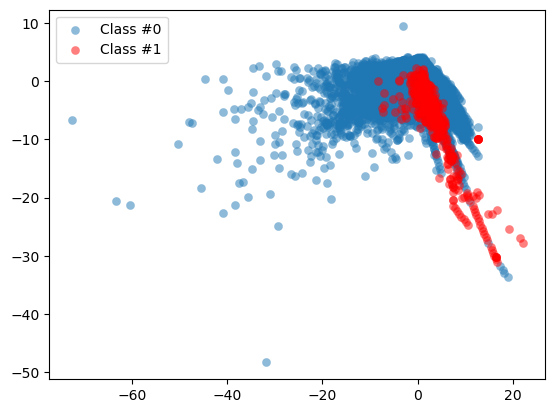

In [11]:
# Plot our data by running our plot data function on X and y
plot_data(X, y)

In [12]:
def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

در اینجا با استفاده از روش 

over sampler

داده های را متوازن و رسم کردیم 

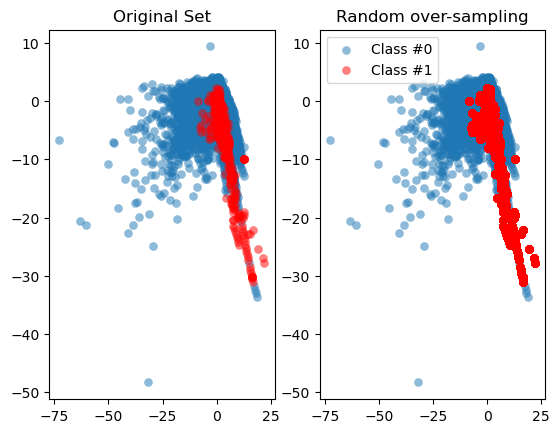

In [13]:
from imblearn.over_sampling import RandomOverSampler

method = RandomOverSampler()
X_resampled, y_resampled =  method.fit_resample(X, y)

compare_plot(X, y ,X_resampled, y_resampled, method='Random over-sampling')

در اینجا با استفاده از روش 

border line smote

داده ها را متوازن کرده و انواع مختلف مدل های کلاس بندی را اجرا کردیم 

# Logistic regression

In [14]:
# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     85296
           1       0.20      0.86      0.32       147

    accuracy                           0.99     85443
   macro avg       0.60      0.93      0.66     85443
weighted avg       1.00      0.99      1.00     85443

Confusion matrix:
 [[84772   524]
 [   20   127]]


# Random forest 

In [15]:
# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = RandomForestClassifier()
pipeline = Pipeline([('SMOTE', resampling), ('Random Forest Classifier', model)])
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.91      0.80      0.86       147

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85285    11]
 [   29   118]]


# Decision tree

In [16]:
# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = DecisionTreeClassifier()
pipeline = Pipeline([('SMOTE', resampling), (' Decision Tree Classifier ', model)])
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.59      0.75      0.66       147

    accuracy                           1.00     85443
   macro avg       0.80      0.87      0.83     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85220    76]
 [   37   110]]


# KNN

In [19]:
# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = KNeighborsClassifier(n_neighbors=2)
pipeline = Pipeline([('SMOTE', resampling), (' K Neighbors Classifier ', model)])
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.89      0.75      0.81       147

    accuracy                           1.00     85443
   macro avg       0.94      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85282    14]
 [   37   110]]


در اینجا داده ها را نرمالایز میکنیم و بعد مدل مورد نظر را اموزش میدهیم

In [12]:
#normalize X
from sklearn import preprocessing
import pandas as pd
X = preprocessing.normalize(X)


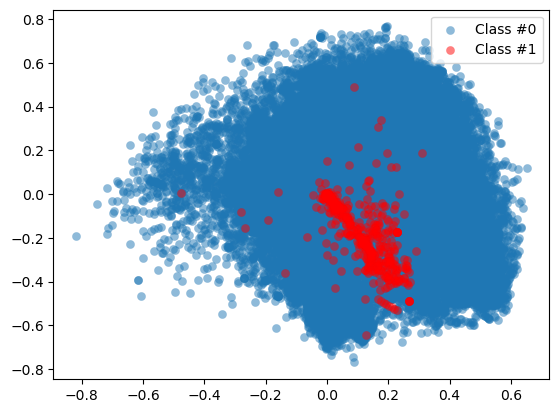

In [13]:
# Plot our data by running our plot data function on X and y
plot_data(X, y)

# KNN

In [16]:
# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
from sklearn.neighbors import KNeighborsClassifier
resampling = BorderlineSMOTE()
model = KNeighborsClassifier(n_neighbors=2)
pipeline = Pipeline([('SMOTE', resampling), ('KNN', model)])
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.87      0.72      0.79       147

    accuracy                           1.00     85443
   macro avg       0.93      0.86      0.89     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85280    16]
 [   41   106]]
